# <span style='font-family:"Times New Roman"'> <span styel=''>**PAN CANCER GENOME INSTABILITY PLOT**
*Emile Cohen*
    
 *May 2020*

**Goal:** In this notebook, we want to summarize Genome instability differences in subgroups across all cancers. For that we will plot the fraction of genome altered for each subgroup for eahc cancer.

---

In [13]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from cancer_utils import *
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec

data_path = '../../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [155]:
mc = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
palette ={'>=1_LOSS':mc[0], 'HOMDEL':mc[1], '1_WILD_TYPE':mc[2], '>1muts':mc[3], '>=1_cnLOH':mc[4], '0_HETLOSS':mc[5]}
palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
master = load_clean_up_master(data_path + 'merged_data/master_file.pkl')

# cancer list 
cancer_count = get_groupby(master[~master['tp53_group'].isna()], 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_list = list(cancer_count[cancer_count['count']>=70].index.values)

Text(0, 0.5, 'Fraction of Genome Altered')

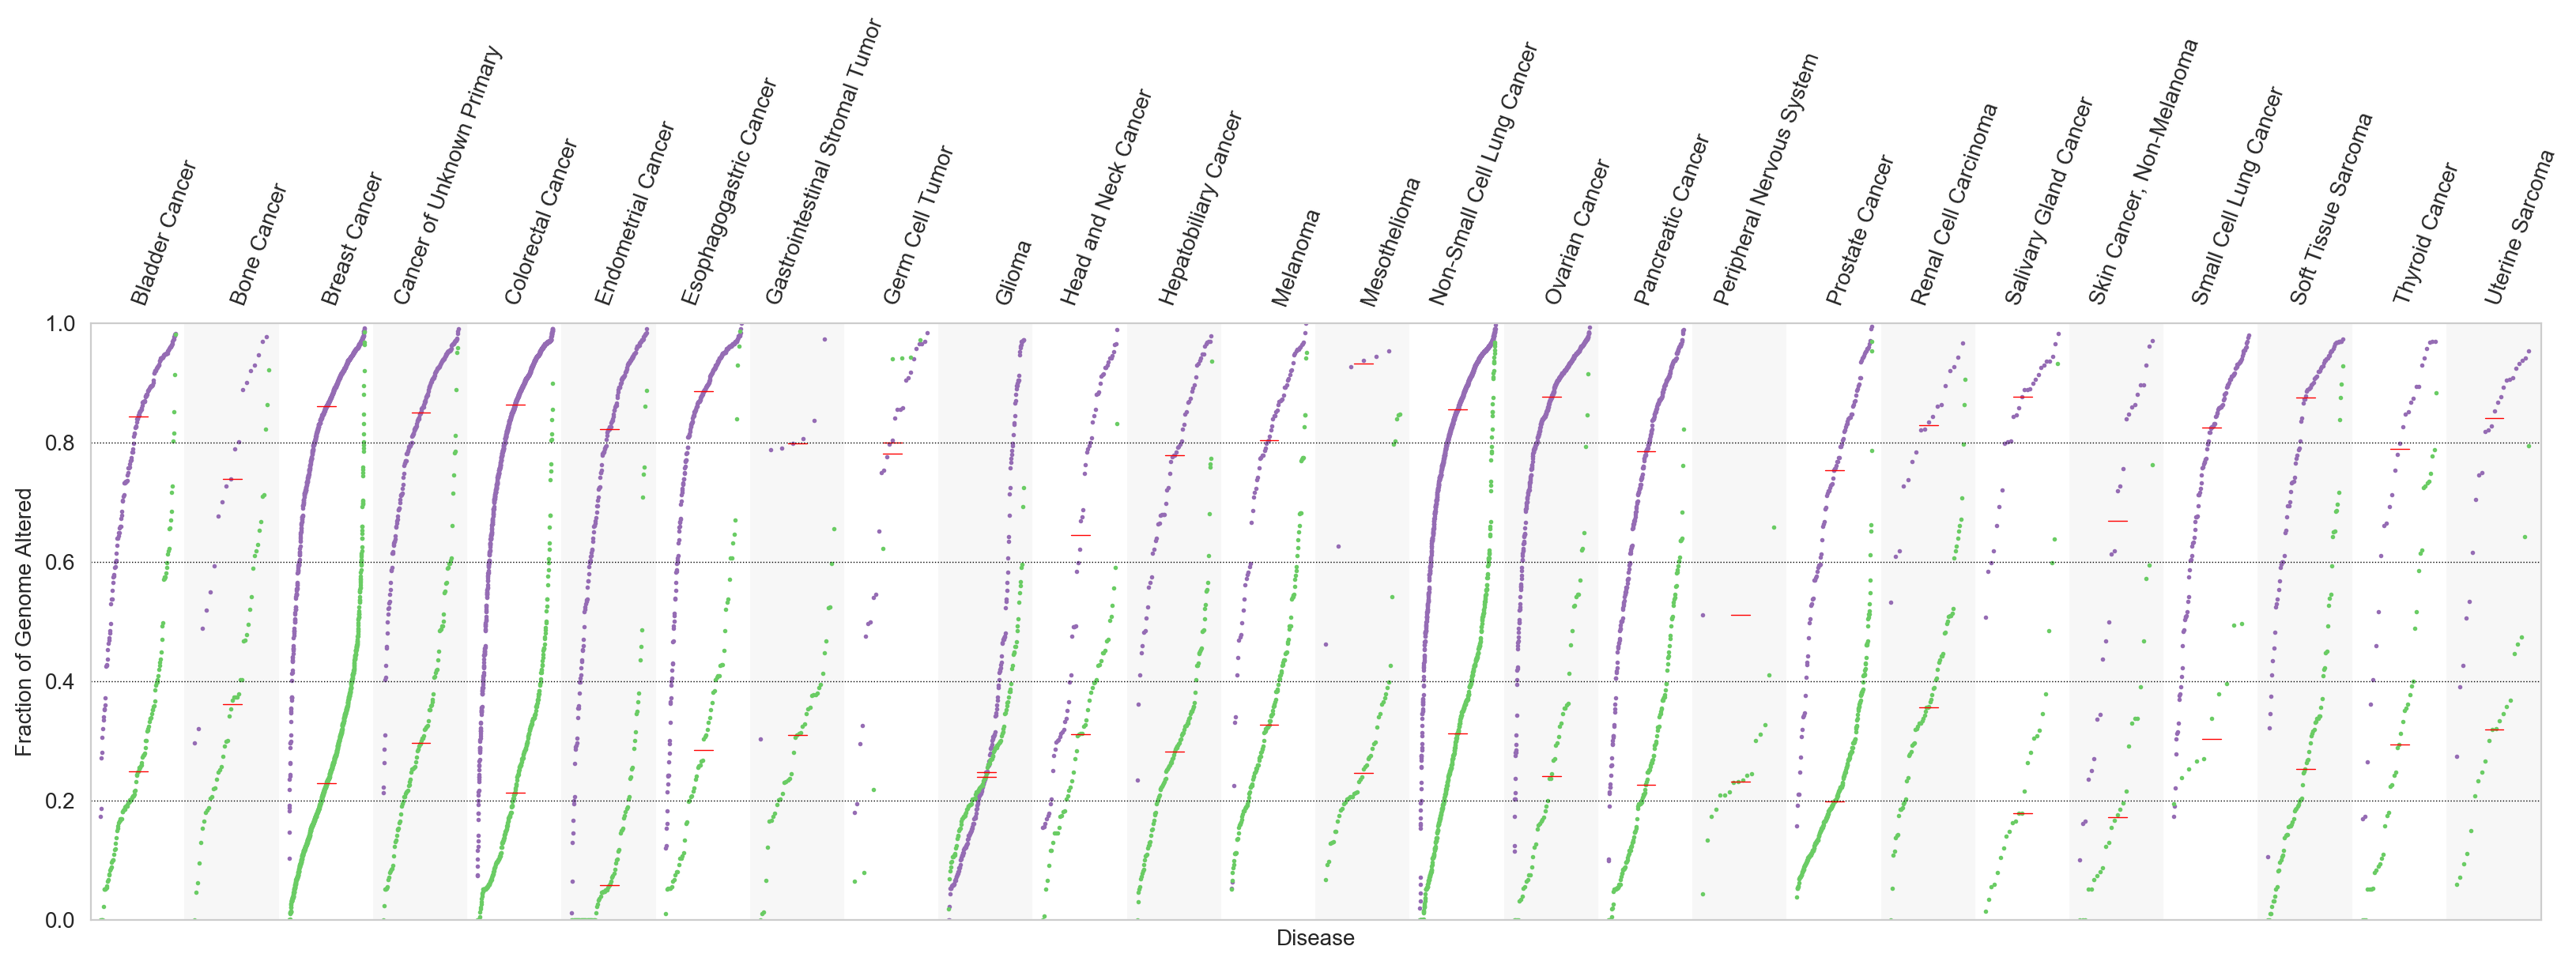

In [64]:
# Let's begin with. one subgroup : >=1_cnLOH
master_cnloh = master[master['tp53_group'] == '>=1_cnLOH']
master_cnloh = master_cnloh[master_cnloh['Cancer_Type'].isin(cancer_list)]

fig = plt.figure(figsize=(20,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

import itertools
col = itertools.cycle(["#FFFFFF","#FFFFFF","#F7F7F7","#F7F7F7"])
labels = []

'''medians = master_cnloh[['Cancer_Type','frac_genome_altered']].groupby('Cancer_Type')['frac_genome_altered']#.median()
display(pd.DataFrame(medians).iloc[0,:])'''
#order = medians.sort_values(ascending=False)
for i, (group, df) in enumerate(master[master['Cancer_Type'].isin(cancer_list)].groupby("Cancer_Type")):
    plt.axvspan(xmin=i-0.5,xmax=i+0.5,color=next(col),zorder=1)
    df_cnloh = df[df['tp53_group'] == '>=1_cnLOH']
    df_mono = df[df['tp53_group'].isin(['1_WILD_TYPE','0_HETLOSS'])]
    labels.append(group)
    #totalsamples = df.shape[0]
    totalsamples_cnloh = df_cnloh.shape[0]
    totalsamples_mono = df_mono.shape[0]
    df_cnloh = df_cnloh.sort_values("frac_genome_altered")
    df_mono = df_mono.sort_values("frac_genome_altered")
    #df = df.sort_values("frac_genome_altered")
    '''for j,(_,row) in enumerate(df.iterrows()):
        plt.scatter(i-0.4+(j/totalsamples)*0.8,row["frac_genome_altered"],color=palette['>=1_cnLOH'],s=1,zorder=2)'''
    for j,(_,row) in enumerate(df_cnloh.iterrows()):
        plt.scatter(i-0.4+(j/totalsamples_cnloh)*0.8,row["frac_genome_altered"],color=palette['>=1_cnLOH'],s=1,zorder=2)
    for j,(_,row) in enumerate(df_mono.iterrows()):
        plt.scatter(i-0.4+(j/totalsamples_mono)*0.8,row["frac_genome_altered"],color=palette['1_WILD_TYPE'],s=1,zorder=2)
    
    median_cnloh  = df_cnloh["frac_genome_altered"].median()
    median_mono  = df_mono["frac_genome_altered"].median()
    plt.plot([i-0.1,i+0.1],[median_mono,median_mono],color="red", linewidth=0.5)
    #median = df["frac_genome_altered"].median()
    plt.plot([i-0.1,i+0.1],[median_cnloh,median_cnloh],color="red", linewidth=0.5)
#plt.yscale("log")
num_dis = len(master[master['Cancer_Type'].isin(cancer_list)]["Cancer_Type"].unique())
ax.xaxis.tick_top()
plt.xticks([k+0.3 for k in range(num_dis)], labels, rotation=70)
ax.xaxis.set_ticks_position('none')
plt.xlim(-0.5,num_dis-0.5)
plt.ylim(0,1)
# Grid
plt.plot([-0.5,25.5],[0.2,0.2],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,25.5],[0.4,0.4],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,25.5],[0.6,0.6],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,25.5],[0.8,0.8],color="black", linewidth=0.5, linestyle=':')
plt.xlabel("Disease")
plt.ylabel("Fraction of Genome Altered")

In [156]:
# Filter and order the samples in order to plot with decreasing medians on the cnloh subgroup
master_list = master[master['Cancer_Type'].isin(cancer_list)]
master_list_cnloh = master_list[master_list['tp53_group'] == '>=1_cnLOH']
cancer_order = master_list_cnloh.groupby('Cancer_Type')['frac_genome_altered']\
                                .apply(np.median)\
                                .sort_values(ascending=False)\
                                .index\
                                .tolist()
samples_list_ordered=[]
for cancer in cancer_order:
    samples_list_ordered = samples_list_ordered + master_list[master_list['Cancer_Type'] == cancer].index.tolist()
samples_list_ordered

master_ordered = master_list.reindex(samples_list_ordered)

CPU times: user 3min 21s, sys: 18.2 s, total: 3min 39s
Wall time: 1min 13s


Text(0, 0.5, 'Fraction of Genome Altered')

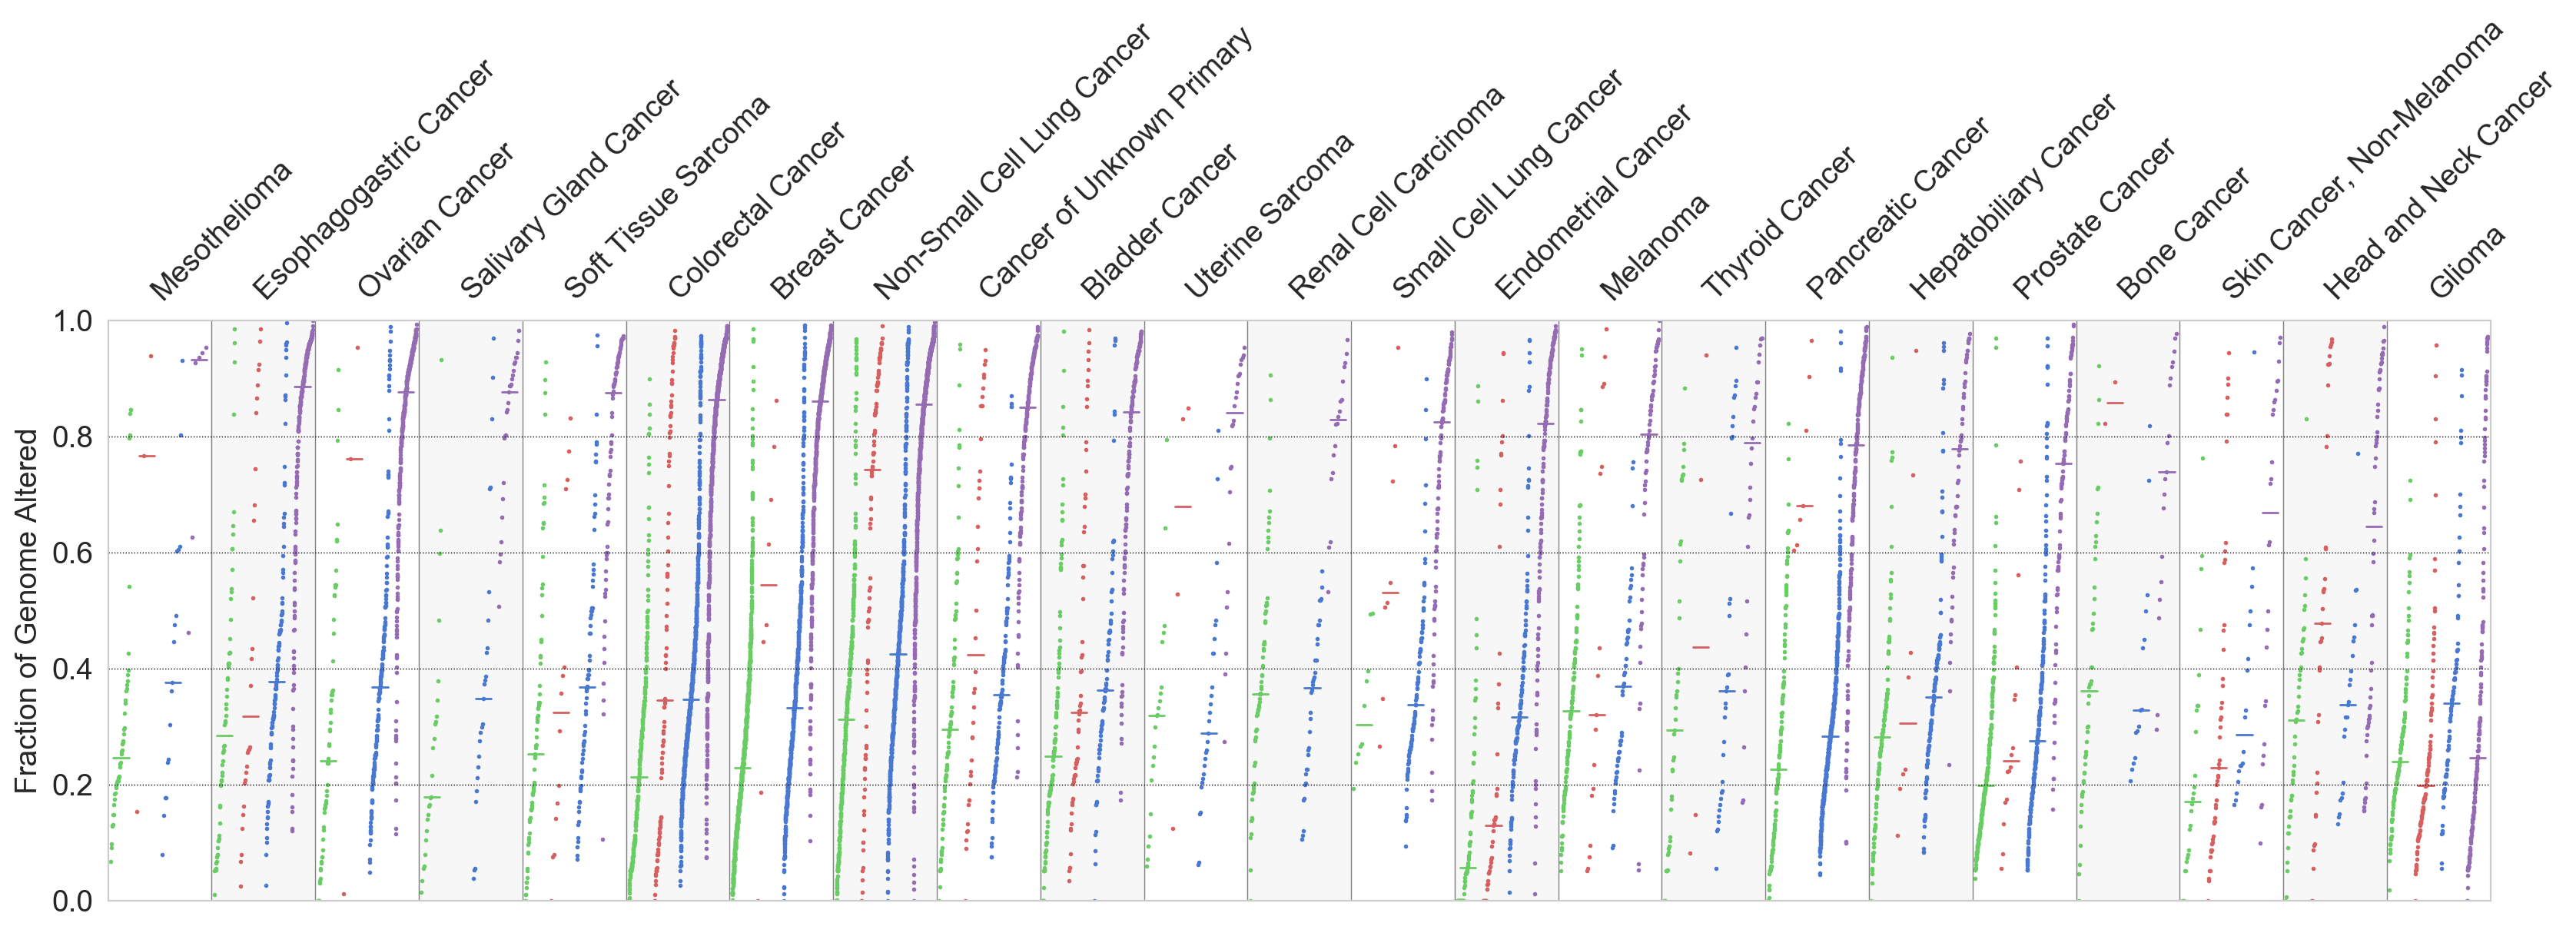

In [157]:
%%time
# Let's begin with. one subgroup : >=1_cnLOH
sns.set_style("whitegrid", {'grid.color': '1.'})

fig = plt.figure(figsize=(20,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

import itertools
col = itertools.cycle(["#FFFFFF","#FFFFFF","#FFFFFF","#FFFFFF","#F7F7F7","#F7F7F7","#F7F7F7","#F7F7F7"])
labels = []

#order = medians.sort_values(ascending=False)
for i, (group, df) in enumerate(master_ordered.groupby(by="Cancer_Type", sort=False)):
    i = 4*i
    labels.append(group)
    
    # Mono Allelic Subgroup in GREEN
    df_mono = df[df['tp53_group'].isin(['1_WILD_TYPE','0_HETLOSS'])]
    totalsamples_mono = df_mono.shape[0]
    df_mono = df_mono.sort_values("frac_genome_altered")
    plt.axvspan(xmin=i-0.5,xmax=i+0.5,color=next(col),zorder=1)
    if totalsamples_mono>0:
        for j,(_,row) in enumerate(df_mono.iterrows()):
            plt.scatter(i-0.4+(j/totalsamples_mono)*0.8,row["frac_genome_altered"],color=palette['1_WILD_TYPE'],s=1,zorder=2)

        median_mono  = df_mono["frac_genome_altered"].median()
        plt.plot([i-0.3,i+0.3],[median_mono,median_mono],color=palette['1_WILD_TYPE'], linewidth=1)
    
    # >1muts Subgroup in RED
    k = i+1
    df_muts = df[df['tp53_group'] == '>1muts']
    totalsamples_muts = df_muts.shape[0]
    df_muts = df_muts.sort_values("frac_genome_altered")
    plt.axvspan(xmin=k-0.5,xmax=k+0.5,color=next(col),zorder=1)
    if totalsamples_muts>0:
        for j,(_,row) in enumerate(df_muts.iterrows()):
            plt.scatter(k-0.4+(j/totalsamples_muts)*0.8,row["frac_genome_altered"],color=palette['>1muts'],s=1,zorder=2)
    
        median_muts  = df_muts["frac_genome_altered"].median()
        plt.plot([k-0.3,k+0.3],[median_muts,median_muts],color=palette['>1muts'], linewidth=1)

    # LOSS Subgroup in BLUE
    h = i+2
    df_loss = df[df['tp53_group']=='>=1_LOSS']
    totalsamples_loss = df_loss.shape[0]
    df_loss = df_loss.sort_values("frac_genome_altered")
    plt.axvspan(xmin=h-0.5,xmax=h+0.5,color=next(col),zorder=1)
    if totalsamples_loss>0:
        for j,(_,row) in enumerate(df_loss.iterrows()):
            plt.scatter(h-0.4+(j/totalsamples_loss)*0.8,row["frac_genome_altered"],color=palette['>=1_LOSS'],s=1,zorder=2)

        median_loss  = df_loss["frac_genome_altered"].median()
        plt.plot([h-0.3,h+0.3],[median_loss,median_loss],color=palette['>=1_LOSS'], linewidth=1)

    # CNLOH Subgroup in PURPLE
    g = i+3
    df_cnloh = df[df['tp53_group'] == '>=1_cnLOH']
    totalsamples_cnloh = df_cnloh.shape[0]
    df_cnloh = df_cnloh.sort_values("frac_genome_altered")
    plt.axvspan(xmin=g-0.5,xmax=g+0.5,color=next(col),zorder=1)
    if totalsamples_cnloh>0:
        for j,(_,row) in enumerate(df_cnloh.iterrows()):
            plt.scatter(g-0.4+(j/totalsamples_cnloh)*0.8,row["frac_genome_altered"],color=palette['>=1_cnLOH'],s=1,zorder=2)

        median_cnloh  = df_cnloh["frac_genome_altered"].median()
        plt.plot([g-0.3,g+0.3],[median_cnloh,median_cnloh],color=palette['>=1_cnLOH'], linewidth=1)
    
    plt.plot([g+0.5,g+0.5],[0,1],color='#7F7F7F', linewidth=0.5)
    #median = df["frac_genome_altered"].median()
  
num_dis = len(master[master['Cancer_Type'].isin(cancer_list)]["Cancer_Type"].unique())*4
real_labels = ['']*num_dis
for i,label in enumerate(labels):
    real_labels[4*i + 1] = label
    

ax.xaxis.tick_top()
plt.xticks([k for k in range(num_dis)], real_labels, rotation=45, ha="left", fontsize=14)
ax.xaxis.set_ticks_position('none')
plt.xlim(-0.5,num_dis-0.5)
plt.ylim(0,1)
# Grid
plt.plot([-0.5,num_dis+0.5],[0.2,0.2],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.4,0.4],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.6,0.6],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.8,0.8],color="black", linewidth=0.5, linestyle=':')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel("")
plt.ylabel("Fraction of Genome Altered", fontsize=14)


In [135]:
arm_level = pd.read_csv(data_path + 'impact-facets-tp53/raw/default_qc_pass.arm_level.txt', sep='\t')

In [149]:
get_groupby(master[master['purity'].isna()][['chr_affected']], 'chr_affected', 'count')#.median()

,count
chr_affected,
0.0,72
1.0,64
2.0,34
3.0,20
4.0,26
5.0,19
6.0,7
7.0,5
8.0,4
